# Exercise 9: molecular dynamics of Lennard-Jones clusters
ETH Zürich: Molecular and Materials Modelling, FS 2023
Prof. Dr. Daniele Passerone, Dr. Carlo A. Pignedoli
TA: Raymond Amador

Date: Wednesday 26. April 2023
Submission deadline: 18h on Sunday, 7. May 2023

----------------------------

## 0. Introduction to the problem

The radial distribution function $g(r)$ provides valuable information about the underlying structure of a cluster (molecule, etc.) and, for a monatomic isotroptic material, expresses the probability to find a pair of species a distance $r$ apart, relative to an ideal gas at the same density. We interpret the peaks in $g(r)$ as interatomic spacing: since x-rays are scattered by electrons, constructive interference as a result of x-ray diffraction is only present if the change in wavevector $\textbf{Q} = \textbf{q} - \textbf{q'}$ is a reciprocal lattice vector itself (see \textit{Ashcroft} for a deeper explanation).

![The radial distribution function for a LJ liquid near the triple point.](LJ_radial.png "Figure 1")

## 1. Preparation for the exercise

In this exercise we will generate ~~four~~ two molecular dynamics (MD) simulations of the clusters in below: 

![Clusters that we will use for MD simulations.](lj_clusters.png "Figure 2")

We begin by logging into our accounts on JupyterHub on Euler in a similar manner as described in the previous exercises, and `pull` the newest exercise files from the GitHub repository, making sure that you are in the directory for the course:
```bash
    $ cd ~/Molecular-and-Materials-Modelling-FS2023
    $ git init
  # $ git stash
    $ git pull https://github.com/ramador09/Molecular-and-Materials-Modelling-FS2023.git
```  

First, execute the following cells to import necessary modules and libraries, and to define the `view_structure()` and `view_trajectory()` functions, which we will make ample use of in the course of this exercise:

In [ ]:
import numpy as np
from ase.io import read
from ase.visualize import view
import matplotlib.pyplot as plt
import nglview as nv

In [ ]:
def view_structure(system):
    t = nv.ASEStructure(system) 
    w = nv.NGLWidget(t, gui=True)
   # w.add_spacefill()
    return w

In [ ]:
def view_trajectory(trajectory):
    t2 = nv.ASETrajectory(trajectory)
    w2 = nv.NGLWidget(t2, gui=True)
    w2.add_spacefill()
    return w2

## 2. Cluster simulations: 38-atom cluster

In the `exercise9` directory you can find the four already-optimized geometries of the above figure (namely `38atoms.xyz`, `150atoms.xyz`, `450atoms.xyz` and `817atoms.xyz`) as well as two types of input files (`production_n.inp`, `thermalization_n.inp`) for each of the geometries. There are of two types of input files because the analysis of molecular dynamics must be done on a **thermalized** system. Therefore, it is necessary to perform two simulations for each system: 

1. a **thermalization** run to achieve thermal equilibrium of the system with a reservoir; and
2. a **production** run to collect energies and trajectories of interest.

By way of example, we will have a closer look at the following two files:


* `thermalization_38.inp` is the input file that allows us to perform a themalization run in the canonical ensemble. In practice the system under analysis is put in contact with a thermostat and brought to equilibrium. This input file is prepared for the 38 atoms cluster;
* `production_38.inp` is the input for a production run in the microcanonical ensemble for the 38 atoms cluster. This run will start from the final point of the previous calculation and maintains the energy of the system constant. It is the result of this simulation which will be analysed.

### 2.1. Preliminaries

The following cell simply defines two parameters of the LJ potential, which we introduced in exercise 3: 

\begin{equation}
        V_{LJ} (r) = 4 \varepsilon \left[ \left( \frac{\sigma}{r}\right)^{12} - \left( \frac{\sigma}{r}\right)^{6}\right],
\end{equation}

for the size parameter $\sigma$, the energy parameter $\epsilon$, and interatomic distance $r$.

In [3]:
## -- only use this cell if you don't want dimensionless quantities -- ##  

sigma   = 3.405
epsilon = 119.8*8.616733e-5 # eV

### 2.2. The `.inp` file: a closer look

Open the `thermalization_38.inp` input file in vim. The `&GLOBAL` and `&FORCE_EVAL` sections are nearly identical to those of exercise 3, while the motion part is modified.

```
&MOTION			       
 &MD
   ENSEMBLE NVT ! fixed number, volume, temperature
   STEPS 100000
   TIMESTEP 0.5 ! timestep in fs
   TEMPERATURE 20.0 ! set the temperature to 20K
   &PRINT
       &ENERGY SILENT
          &EACH
             MD 10
          &END
       &END
    &END
 
    &THERMOSTAT
      TYPE CSVR ! canonical sampling through velocity rescaling 
      &CSVR
        TIMECON 5000 ! timeconstant: rescale the velocity every 5000 steps
      &END
    &END THERMOSTAT
  &END MD
 
 &PRINT
  &RESTART
    &EACH
        MD 0
    &END
  &END
  &RESTART_HISTORY OFF
  &END
  &TRAJECTORY on
   FORMAT xyz		       
   &EACH		       
    MD 1000 ! information on trajectory printed every 1000 steps
   &END EACH
  &END TRAJECTORY
 &END PRINT
&END MOTION
```

### 2.3. Converging the time steps

A common theme in computational sciences is the convergence of necessary parameters which are relevant to a particular calculation. Before we proceed to our actual calculations, we need to first converge the number of time steps. Find the the `&MOTION` code block, and notice that the value of the `STEPS` keyword is `10000` which is indeed quite a low number. Nonetheless leave it as is for now and close the file.

Having learned quite a few methods to submit calculations over the past few weeks, submit the calculation either on Euler or on Daniele's Eiger account, both of which have been outlined in previous exercises. As a brief recap:

* for the submission script on Eiger:

    ```bash
    $ sbatch -J <username>  --export=ALL,root=<input_file> run
    ```

    assuming a clean `ssh` to Eiger, and where the `run` script is that from exercise 8 (see the Jupyter notebook of exercise 8 for more details!).

* for the submission on Euler using `sbatch`, the submission script looks like: 

    ```bash
    #!/bin/bash

    #SBATCH -N 1
    #SBATCH -n 9
    #SBATCH --time=4:00:00
    #SBATCH --job-name="nice name"
    #SBATCH --mem-per-cpu=1024
    #SBATCH --output=stdout.txt
    #SBATCH --error=stderr.txt

    # module load openmpi/4.0.2
    # module load gcc/6.3.0 openmpi/4.0.2 cp2k/8.2
    /cluster/home/ramador/cp2k.ssmp -i input.inp > output.out
    ```
* for the submission on Euler directly from the command line:

    ```bash
    $ /cluster/home/ramador/cp2k.ssmp -i input.inp > output.out
    ```

Whichever you choose, the calculation should not take very long. We want to now plot the stability of the temperature vs. time step in order to see if we have reached convergence. Execute this coce block to plot temperature vs. time step:

Text(0, 0.5, 'T [K]')

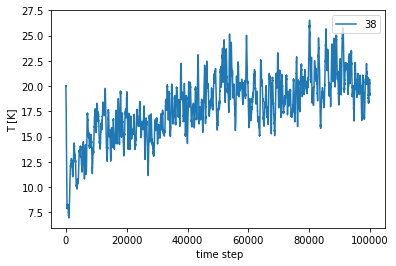

In [5]:
data38_therm  = np.loadtxt('./thermalization_38-1.ener' )
data38_therm  = np.transpose(data38_therm)
plt.plot(data38_therm[0],data38_therm[3], label='38')
plt.legend( loc='upper right')
plt.xlabel(' time step')
plt.ylabel('T [K]')

#### Assignment 1: Plot analysis

Examine the graph. Are we satisfied with the stability? If so, proceed to the next section; if not, go back to the input file `thermalization_38.inp` and change (read: increase!) the `STEPS` parameter. The number of simulation steps should be determined according to the criteria mentioned in the theory: this converged number of steps is that which we will use for the duration of this exercise. *Answer*: we're not satisfied with the stability (or here: lack thereof). It needs about 200000 steps. Plot it :D

In [ ]:
##-- Your code here

#### End Assignment 1

### 2.4. Production simulation

We next perform the production simulation. Open the corresponding `production_38.inp` input file. Because we want the production run to restart from the thermalization run, we will need an extra section in the new input file that tells CP2K to restart the simulation as indicated by a `.restart` file:

```
&EXT_RESTART
  RESTART_FILE_NAME thermalization_38-1.restart
&END
```

Having performed the thermalization within the canonical ensemble, we now want to perform the data production simulation within the **microcanonical ensemble**. Observe how the `&MOTION` section in the `production_38.inp` is modified from `ENSEMBLE NVT` for the canonical ensemble to `ENSEMBLE NVE` for the microcanonical ensemble. Additionally, we notice that the setup for the thermostat is not ncecessary anymore.

Submit the production simulation.

## 3. Cluster simulations: the remaining clusters

### 3.1. Thermalization simulation: the 817-atom cluster

#### Assignment 2: Thermalization simulations of the 817-atom cluster

We now repeat the aforementioned calculations of the thermalization (this subsection) and the production (next subsection) for the 817-atom cluster. As was the case for the 38-atom cluster and for the geometry optimizations of  exercise 3, we will require two files for this simulation: (i) an XYZ geometry file, and (ii) an input file. Thus, for the remaining clusters, we still need to create an input file specific for the system. Here the example procedure for the 817-atom cluster is outlined:
1. For the input file:
    - copy the input file of the 38-atom cluster into a new input file named according to the number of atoms contained in the cluster: `$ cp thermalization_38.inp thermalization_817.inp`
    - open it by double-clicking resp. using the `vim` or `nano` editors
    - change the name of the project in the `GLOBAL` section: `PROJECT thermalization_817`
    - change the name of the starting geometry: `COORD_FILE_NAME 817atoms.xyz`
    - save and close the file

2. Submit the calculations.

In [15]:
##-- Your code here

#### End Assignment 2

### 3.2. Production simulation: the remaining clusters

#### Assignment 3: Production simulations of the remaining clusters
In this exercise, we briefly outline the procedure for the production simulation. As
in the previous case we have to create an input file according to the system. Again
the case of 817 atoms cluster is explained step by step:
1. For the input file:
    - copy the input file of the 38 atoms one in a new one named according to the number of elements of the cluster: `$ cp production_38.inp production_817.inp`
    - double-click on the newly created input file to open it in a new Launcher tab.
    - change the name of the project in the `GLOBAL` section: `PROJECT production_817`
    - change the name of the restarting file: `RESTART_FILE_NAME thermalization_817-1.restart`
    - change the name of the starting geometry: `COORD_FILE_NAME 817atoms.xyz`
    - save and close the file
2. Submit the calculation.

In [16]:
##-- Your code here

#### End Assignment 3

## 4. Trajectories - clusters

### 4.1. The 38-atom cluster

We now want to visualize the trajectory of the 38-atom cluster, in exactly the same fashion as the during the previous exercise session. Let us define a quantity `traj_38` to do this:

In [6]:
traj_38 = read('production_38-pos-1.xyz', index=':')
view_trajectory(traj_38)

NGLWidget(max_frame=399)

### 4.2. Trajectories: the 817-atom cluster

#### Assignment 4: Trajectory of the 817-atom cluster
Visualize the trajectory of the 817-atom cluster, making changes
to variable names where appropriate, and comment on some of the features (partic-
ularly in regards to symmetries).

In [ ]:
##-- Your code here

#### End Assignment 4

## 5. Thermalization plots (NVT)


One of the output files of the calculations is the `.ener` file, which is organized as follows:

* column 0: timestep number
* column 1: elapsed total time (usually fs)
* column 2: kinetic energy
* column 3: temperature
* column 4: potential energy

In this and the following section we want to plot a few of these values for the 38-atom cluster; it will then be your task (via the exercises) to plot the rest. Begin by importing the data from the respective `.ener` file by executing the code block, and, in doing so, plotting a graph of the absolute temperature vs total elapsed time. It should look quite similar to the plot in which we converged the timestep parameter (why?):

Text(0, 0.5, 'T [K]')

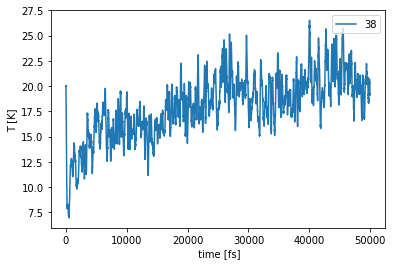

In [7]:
data38_therm  = np.loadtxt('./thermalization_38-1.ener' )
data38_therm  = np.transpose(data38_therm)
plt.plot(data38_therm[1],data38_therm[3], label='38')
plt.legend( loc='upper right')
plt.xlabel(' time [fs]')
plt.ylabel('T [K]')

## 6. Production plots (NVE)

We now want to plot the dynamics of the system in the microcanonical ensemble, which are contained in the `.ener` files from the production runs. The layout of the `.ener` file in the production run is the same as that in the thermalization runs. Execute

Text(0, 0.5, 'T [K]')

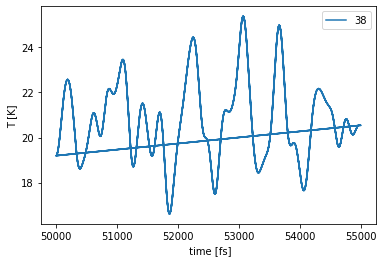

In [8]:
data38_prod  = np.loadtxt('production_38-1.ener' )
data38_prod  = np.transpose(data38_prod)
plt.plot(data38_prod[1],data38_prod[3], label='38')
plt.legend( loc='upper right')
plt.xlabel(' time [fs]')
plt.ylabel('T [K]')

## 7. Radial distribution function

### 7.1. The 38-atom cluster

We next come to our graphical representation of the radial distribution function, which we met in today's lecture and in the introduction of this exercise session. Execute the code block defining the `g_step()` function, which takes three parameters and will help us define the **radial distribution function**:

In [9]:
def g_step(box, n_bin, d):
    """
    Calculates the radial distribution function g(r) for a given box size, number of bins and a distance matrix d,
    at some time step (hence the name g_step).

    Args:
        box (float): side length of the box
        n_bin (int): number of bins
        d (numpy.ndarray): distance matrix
    
    Returns:
        g (numpy.ndarray): radial distribution function at a given time step
    """

    box    += 1 
    box    *= np.sqrt(2)/sigma # to get dimensionless units
    del_bin = box/n_bin  # width of a bin in dimensionless units
    
    g    = np.zeros([n_bin,n_bin]) # g(r) matrix
    g[0] = np.linspace(0,box,n_bin) # first row is the bin edges
    g[0]+= del_bin*0.5 # shift the bin edges to the middle of the bin
    
    for i in range(len(d)): # loop over all particles
        for j in range(i+1,len(d)): # loop over all particles with higher index than i: avoid double counting and self-counting!
            g_index = d[i][j]/(del_bin) # index of the bin in which the distance falls
            g[1,g_index.astype(int)] += 2 
    
            
    
    #normalized by number of particles 
    g[1] /= len(d[0]) 
    #and by bin volume
    
    for k in range(len(g[1])):
        g[1][k] /= ((k+1)**3 -k**3)*del_bin**3
        
    #side of the optimized cell: 5,269 * sigma
    vol = (5.269/sigma)**3 # volume of the optimized cell
    rho = 4./vol # density of the optimized cell
    g[1] /= np.pi*(4/3)*rho # normalize by the density
    return g

We can now plot the radial distribution function for the 38-atom cluster with the help of the `g_step()` function. Execute the following block of code:

Text(0, 0.5, 'radial distribution function')

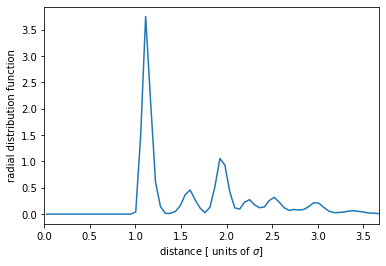

In [10]:
N = len(traj_38[0])    #number of atoms
n_step = len(traj_38)  #number of step

#create a distance array
dist = np.empty([0,N,N])
for frame in traj_38:
    dist = np.append(dist, [frame.get_all_distances()],axis=0)

#Lennard Jones units

dist  /= sigma

#understand what the distance array is:

#dist0 = trajectory[0].get_all_distances()
# print(dist0.shape)
# print(dist0)
# print(dist0[0])
n_bin = 200  #number of bin in the graph
box   = 25   #side of the bin in the simulation 
g_38  = np.zeros([n_bin,n_bin])

#average during the thermalized part of the simulation
for i in range(n_step):
    g_38 += g_step(box,n_bin,dist[i])
g_38 /= n_step

plt.plot(g_38[0],g_38[1])
plt.xlim(0,box/(2*sigma))
plt.xlabel('distance [ units of $\sigma$]')
plt.ylabel('radial distribution function')

#### Assignment 5: Radial distribution function for the 817-atom cluster
Appropriately modify the code in cell above in order to generate plots of g(r) for the 817-atom cluster. Hint: you shouldn’t have to change so much code
here – obviously you’ll need to change the names of variables, but you might want
to play around with (i.e.: increase!) the values for the n_bin and box variables so
that you get a relatively "smooth" plot.

In [19]:
##--Your code here

#### End Assignment 5

#### OPTIONAL Assignment 6: radial distribution functions of the 150- and 450-atom clusters.

In the parent `exercise9` directory, you will see geometry files for other clusters: namely, those of the 150- and 450-atom clusters. Perform the steps of the above calculations (thermalization, production runs) in order to arrive at the radial distribution functions for the 150- and 450-atom clusters. Comment on your findings.

In [ ]:
## -- Your code here

#### End Assignment 6

## 8. Analysis of the bulk

Bulk structures are inherently different from the several-atom clusters we examined above, in that bulk crystals exhibit periodicity in one, two, or (here) three spatial dimensions. We will now repeat a MD simulation for a crystal structure. We take a Lennard-Jones super-cell made of $6 \times 6$ conventional cells (`crystal_6x6.xyz`). Have a look at the input file `thermalization_bulk.inp` . Notice that the only differences are given in the system part in the `&FORCE_EVAL` section, where the system is set to periodic via `PERIODIC XYZ` and the cell size is changed. Run the calculation.


Once this calculation is concluded, we perform the production run. The input file is again analogous to the one of the clusters, but for the properties of the system. You can inspect the input file `production_bulk.inp`. Once you are convinced, run the calculation.

### 8.1. 20 K
When it is concluded, we can visualize the trajectory of the bulk system by running the cell block containing the trajectory for the 20 K bulk system:

In [11]:
traj_20_bulk = read('production_bulk-pos-1.xyz', index=':')
view_trajectory(traj_20_bulk)

NGLWidget(max_frame=99)

Text(0, 0.5, 'radial distribution function')

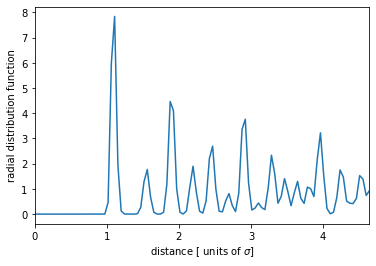

In [12]:
unit_cell_side = 5.269 # side of the unit cell in the simulation
cell_side = 6*unit_cell_side # multiply by 6 to get the side of the bulk cell

#create a distance array
N = len(traj_20_bulk[0])    #number of atoms
n_step = len(traj_20_bulk)  #number of step
dist = np.empty([0,N,N])
for frame in traj_20_bulk:
    frame.set_cell([cell_side,cell_side,cell_side])
    frame.set_pbc((True,True,True))
    dist = np.append(dist, [frame.get_all_distances(mic=True)],axis=0)
    

#Lennard Jones units

dist  /= sigma

n_bin = 300  #number of bin in the graph
box   = cell_side   #side of the bon in the simulation 
g_20  = np.zeros([n_bin,n_bin])

#average during the thermalized part of the simulation
for i in range(n_step):
    g_20 += g_step(box,n_bin,dist[i])
g_20 /= n_step

plt.plot(g_20[0],g_20[1])
plt.xlim(0,box/(2*sigma))
plt.xlabel('distance [ units of $\sigma$]')
plt.ylabel('radial distribution function')

### 8.2. 100 K

#### Assignment 6: $g(r)$ of the bulk structure at 100K
Repeat the procedure for a thermalization to 100K.
1. Copy the input in a new one: `$ cp thermalization_bulk.inp thermalization_bulk_100.inp`
2. Begin the editting process by double-clicking on the file `thermalization_bulk_100.inp`
3. In the `GLOBAL` section change the project name: `PROJECT thermalization_bulk_100` and set the temperature in the `MOTION` section: `TEMPERATURE 100`
4. Save and close and run the simulation.
5. When the simulation is finished, do the same for the production input file: `$ cp production_bulk.inp production_bulk_100.inp`
6. Open the file via double-click: `production_bulk_100.inp`
7. Modify the lines of the current project name `PROJECT production_bulk_100` and of the restart file name `RESTART_FILE_NAME thermalization_bulk_100-1.restart`
8. Run the calculation with the following line in the terminal: `$ cp thermalization_bulk.inp thermalization_bulk_100.inp`

Then perform the same steps as just before to visualize the trajectory and plot $g(r)$.

In [ ]:
N = len(traj_100_bulk[0])    #number of atoms

n_step = len(traj_100_bulk)  #number of step
n_step
#create a distance array
dist = np.empty([0,N,N])
for frame in traj_100_bulk:
    frame.set_cell([cell_side,cell_side,cell_side])
    frame.set_pbc((True,True,True))
    dist = np.append(dist, [frame.get_all_distances(mic=True)],axis=0)

#Lennard Jones units

dist  /= sigma

n_bin  = 300  #number of bin in the graph
box    = cell_side #side of the simulation box
g_100  = np.zeros([n_bin,n_bin])

#average during the thermalized part of the simulation
for i in range(n_step):
    g_100 += g_step(box,n_bin,dist[i])
g_100 /= n_step

plt.plot(g_100[0],g_100[1])
plt.xlim(0,box/(2*sigma))
plt.xlabel('distance [ units of $\sigma$]')
plt.ylabel('radial distribution function')
#plt.savefig("gr.png",  dpi=300,transparent=True)

In [ ]:
plt.plot(g_100[0],g_100[1], label='100')
plt.plot(g_20[0],g_20[1], label='20')
plt.legend( loc='upper right')
plt.xlim(0,box/(2*sigma))
plt.xlabel('distance [ units of $\sigma$]')
plt.ylabel('radial distribution function')

#### End Assignment 6

#### Assignment 7: Extracting quantities of interest from the $g(r)$

Now that we have $g(r)$ for the clusters as well as the bulk, it's now time to see how we can use them to extract quantities of interest. The most fundamental quantity is, of course, the **energy**.

Recall that energy of a system $E$ is related to the canonical partition function $\mathcal{Z}(N,V,\beta)$ (for number of particles $N$, volume $V$, and inverse temperature $\beta=1/k_BT$) by

$$
E(N,V,\beta) = - \frac{∂}{∂\beta}\ln \mathcal{Z}(N,V,\beta).
$$

It can be shown that 

$$
E = \frac{3}{2}Nk_BT + \frac{N}{2}4 \pi \rho \int_0^\infty r^2 u(r) g(r) dr,
$$

for some pair potential $u(r)$ of interparticle distance $r$, and number density $\rho = N/V$.

Use the Lennard-Jones potential (Eq. 1 in this Jupyter notebook) as the $u(r)$ and calculate (or plot) the energy of the above systems after the production runs: the 39-atom and 817-atom clusters, as the bulk system at both 20K and 100K. Comment on your results.

Then do the same for the **pressure** $p$

$$
\beta p = \rho - \frac{\beta \rho^2}{6} \int_0^\infty 4\pi r^3 \frac{∂u}{∂r} g(r) dr,
$$

and the **static structure factor** $S(k)$ for wavenumber $k$ in an isotropic fluid,

$$
S(k) = 1 + 4 \pi \rho \int_0^\infty r^2 g(r) \frac{\sin(kr)}{kr}dr.
$$

The latter quantity is of particular interest to collaborations between theory and experiment, as the $S(k)$ is directly measurable via neutron or x-ray diffraction experiments.

In [1]:
## -- Your code here

#### End Assignment 7

<span style="color:red"> **-- WARNING: INTEGRALS IN PYTHON --**
Numerical integration methods (including the `scipy.integrate.quad` function that you'll probably use) can be a tricky topic, and can produce nonsensical results if not handled properly. While the integrals we're doing here behave as expected, you should always exercise care when dealing with numerical integrals: the documentation is always a good place to start.
</span>

#### OPTIONAL Assignment 8: the coordination number

In order to obtain more information on the neighbour distribution of some substance, a useful quantity is the **coordination number** $n_1$ (more properly, the **first** coordination number): 

$$
n_1 = 4 \pi \int_0^{r_m} r^2 g(r) \rho dr,
$$

where $r_m$ is the location of the first minimum. Calculate the coordination number of the above systems.

In [ ]:
## -- Your code here

#### END Assignment 8

## 7. Comparison of energy to that of the clusters

As a conclusion to this exercise, we can now perform the final analysis of the simulations and compute the **surface energy**, which is the measure of the excess energy present at the surface of a material. In the bulk, atoms are generally stable and have a balanced set of bonds and interactions, while at the surface, they have an incomplete and unbalanced set of interactions due to the asymmetry in the direction normal to the surface; therefore, there is unrealised bonding energy. The surface energy $SE$ is defined as relative measurement of the energy at the surface and because of these properties it can be computed as:

\begin{equation}
    SE = E_{cluster}-N_{cluster}\times E_{per \, particle \, of \, the \, bulk}
\end{equation}

Execute the block of code in which we re-import the `.ener` files from each of the four clusters as well as the bulk; this cell block also reconsitutes the data in LJ units:

In [13]:
#COMPARATIVE ENERGY PLOTS

data38  = np.loadtxt('production_38-1.ener' )
data150 = np.loadtxt('production_150-1.ener')
data450 = np.loadtxt('production_450-1.ener')
data817 = np.loadtxt('production_817-1.ener')
dataBulk = np.loadtxt('production_bulk-1.ener')

data38   = np.transpose(data38)
data150  = np.transpose(data150)
data450  = np.transpose(data450)
data817  = np.transpose(data817)
dataBulk = np.transpose(dataBulk)


#energy in simulation time in LJ units
E38   = 27.1442*data38[4]/epsilon #eV / epsilon(eV)
E150  = 27.1442*data150[4]/epsilon 
E450  = 27.1442*data450[4]/epsilon 
E817  = 27.1442*data817[4]/epsilon 
EBulk = 27.1442*dataBulk[4]/epsilon 

#### Assignment 9: Comparison of surface energies
Using the above cell as a starting point, construct plots of the energy per particle (in units of $\varepsilon$ vs. cluster size. The individual steps are as follows:
1. define and initialise a 2 $\times$ 4 numpy array `e_average`, for which the 0th element will contain the cluster size (of which we have four), and the "1th" element will contain the mean energies, which were in turn defined in the block of code above `# energy in simulation time in LJ units`
2. for the bulk system, the average energy is just one number of course and not an array: define and initialise it.
3. next compute the average energy per particle: define again a 2 $\times$ 4 numpy array `e_part`, where the 0th element is the cluster size, and the "1th" element is the average energy per particle
4. for the bulk system: create an array of crystal energy per particle.
5. superimpose the plots of the clusters and of the bulk on top of each other and comment on the results

In [20]:
##--Your code here

#### End Assignment 9

#### Assignment 10
Construct a table in which you plot the difference between the potential energy from
the bulk system and that from each of the clusters. What do you find? Is energy
conserved? *Hint*: what happens to the total energy column (the rightmost column
of the `.ener` file) as a function of time?

In [2]:
##--Your code here

#### End Assignment 10